In [467]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd 
import openpyxl as _ # to make sure it is installed
import numpy as np
import seaborn as sns
pd.set_option("display.max_columns", 100)

red, blue, green = sns.color_palette('Set1', 3)

## Data loading

In [481]:
data_B = pd.read_excel('../data/sequencing/EvoTrisomy_B.xlsx')
data_B.head()

,#CHROM,POS,REF,ALT,QUAL,INFO,Sample_Avihu1_genotype,Sample_Avihu1_Reads_ref,Sample_Avihu1_Fraction_ref,Sample_Avihu1_Reads_alt1,Sample_Avihu1_Fraction_alt1,Sample_Avihu2_genotype,Sample_Avihu2_Reads_ref,Sample_Avihu2_Fraction_ref,Sample_Avihu2_Reads_alt1,Sample_Avihu2_Fraction_alt1,Sample_Avihu4_genotype,Sample_Avihu4_Reads_ref,Sample_Avihu4_Fraction_ref,Sample_Avihu4_Reads_alt1,Sample_Avihu4_Fraction_alt1
0,chr01,230142,G,GTGGGTGT,776.20,AC=3;AF=0.136;AN=22;ActiveRegionSize=194;BaseQ...,0,32,1,0,0,0,16,1,0,0,1,5,0.416667,7,0.583333
1,chr02,19393,C,T,3876.07,ABHet=0.505;ABHom=1.000;AC=2;AF=0.091;AN=22;Ac...,0,253,1,0,0,0,121,1,0,0,1,61,0.512605,58,0.487395
2,chr02,534279,C,A,1158.27,ABHet=0.453;ABHom=0.998;AC=1;AF=0.045;AN=22;Ac...,0,80,1,0,0,0,98,1,0,0,1,28,0.451613,34,0.548387
3,chr02,576193,T,A,1868.27,ABHet=0.490;ABHom=1.00;AC=1;AF=0.045;AN=22;Act...,0,132,1,0,0,0,104,1,0,0,1,52,0.477064,57,0.522936
4,chr04,315072,CT,C,71.86,AC=3;AF=0.136;AN=22;ActiveRegionSize=183;BaseQ...,0,48,1,0,0,0,41,1,0,0,1,42,0.893617,5,0.106383


In [482]:
data_B.drop(columns=['QUAL', 'INFO', 'Sample_Avihu1_genotype', 'Sample_Avihu2_genotype', 'Sample_Avihu4_genotype'], inplace=True)
#                      'Sample_Avihu1_Reads_ref',  'Sample_Avihu1_Reads_alt1',  'Sample_Avihu2_Reads_ref', 'Sample_Avihu2_Reads_alt1', 
#                       'Sample_Avihu4_Reads_ref', 'Sample_Avihu4_Reads_alt1'], inplace=True)
data_B.rename(columns={
    'Sample_Avihu1_Fraction_ref':'ancestor_ref', 'Sample_Avihu1_Fraction_alt1':'ancestor_alt', 
    'Sample_Avihu2_Fraction_ref':'aneuploidy_ref', 'Sample_Avihu2_Fraction_alt1':'aneuploidy_alt',
    'Sample_Avihu4_Fraction_ref':'evolved_ref', 'Sample_Avihu4_Fraction_alt1':'evolved_alt',
    'Sample_Avihu1_Reads_ref':'ancestor_ref_count', 'Sample_Avihu1_Reads_alt1':'ancestor_alt_count', 
    'Sample_Avihu2_Reads_ref':'aneuploidy_ref_count', 'Sample_Avihu2_Reads_alt1':'aneuploidy_alt_count',
    'Sample_Avihu4_Reads_ref':'evolved_ref_count', 'Sample_Avihu4_Reads_alt1':'evolved_alt_count'
}, inplace=True)
data_B.head()

,#CHROM,POS,REF,ALT,ancestor_ref_count,ancestor_ref,ancestor_alt_count,ancestor_alt,aneuploidy_ref_count,aneuploidy_ref,aneuploidy_alt_count,aneuploidy_alt,evolved_ref_count,evolved_ref,evolved_alt_count,evolved_alt
0,chr01,230142,G,GTGGGTGT,32,1,0,0,16,1,0,0,5,0.416667,7,0.583333
1,chr02,19393,C,T,253,1,0,0,121,1,0,0,61,0.512605,58,0.487395
2,chr02,534279,C,A,80,1,0,0,98,1,0,0,28,0.451613,34,0.548387
3,chr02,576193,T,A,132,1,0,0,104,1,0,0,52,0.477064,57,0.522936
4,chr04,315072,CT,C,48,1,0,0,41,1,0,0,42,0.893617,5,0.106383


In [483]:
idx = False
for k in ['ancestor_ref', 'ancestor_alt', 'aneuploidy_ref', 'aneuploidy_alt', 'evolved_ref', 'evolved_alt']:
    if data_B[k].dtype == object:
        idx = idx | data_B[k].str.contains('\*')
data_B = data_B[~idx]
for k in ['ancestor_ref', 'ancestor_alt','aneuploidy_ref', 'aneuploidy_alt', 'evolved_ref', 'evolved_alt']:
    data_B[k] = data_B[k].astype(float)

In [484]:
assert np.allclose(data_B['ancestor_ref'] + data_B['ancestor_alt'] , 1)
assert np.allclose(data_B['aneuploidy_ref'] + data_B['aneuploidy_alt'] , 1)
assert np.allclose(data_B['evolved_ref'] + data_B['evolved_alt'] , 1)

In [485]:
populations = ['ancestor', 'aneuploidy', 'evolved']

for i,t in enumerate(populations):
    n = data_B[t+'_ref_count'] + data_B[t+'_alt_count']
    n = n.astype(int)
    data_B[t+'_total_count'] = n
    p = data_B[t+'_alt']
    e = np.sqrt(p*(1-p)/n)
    data_B[t+'_alt_err'] = e

data_B = data_B[[
    '#CHROM', 'POS', 'REF', 'ALT', 
    'ancestor_total_count', 'ancestor_ref_count', 'ancestor_alt_count', 'ancestor_ref', 'ancestor_alt', 'ancestor_alt_err',
    'aneuploidy_total_count', 'aneuploidy_ref_count', 'aneuploidy_alt_count', 'aneuploidy_ref', 'aneuploidy_alt', 'aneuploidy_alt_err',
    'evolved_total_count', 'evolved_ref_count', 'evolved_alt_count', 'evolved_ref', 'evolved_alt', 'evolved_alt_err']]
print(data_B.shape)
data_B.head()

(186, 22)


,#CHROM,POS,REF,ALT,ancestor_total_count,ancestor_ref_count,ancestor_alt_count,ancestor_ref,ancestor_alt,ancestor_alt_err,aneuploidy_total_count,aneuploidy_ref_count,aneuploidy_alt_count,aneuploidy_ref,aneuploidy_alt,aneuploidy_alt_err,evolved_total_count,evolved_ref_count,evolved_alt_count,evolved_ref,evolved_alt,evolved_alt_err
0,chr01,230142,G,GTGGGTGT,32,32,0,1.0,0.0,0.0,16,16,0,1.0,0.0,0.0,12,5,7,0.416667,0.583333,0.142319
1,chr02,19393,C,T,253,253,0,1.0,0.0,0.0,121,121,0,1.0,0.0,0.0,119,61,58,0.512605,0.487395,0.045820
2,chr02,534279,C,A,80,80,0,1.0,0.0,0.0,98,98,0,1.0,0.0,0.0,62,28,34,0.451613,0.548387,0.063202
3,chr02,576193,T,A,132,132,0,1.0,0.0,0.0,104,104,0,1.0,0.0,0.0,109,52,57,0.477064,0.522936,0.047841
4,chr04,315072,CT,C,48,48,0,1.0,0.0,0.0,41,41,0,1.0,0.0,0.0,47,42,5,0.893617,0.106383,0.044974


In [486]:
data_B.drop(columns=['ancestor_ref', 'aneuploidy_ref', 'evolved_ref', 'ancestor_ref_count', 'aneuploidy_ref_count', 'evolved_ref_count'], inplace=True)

# Quality control

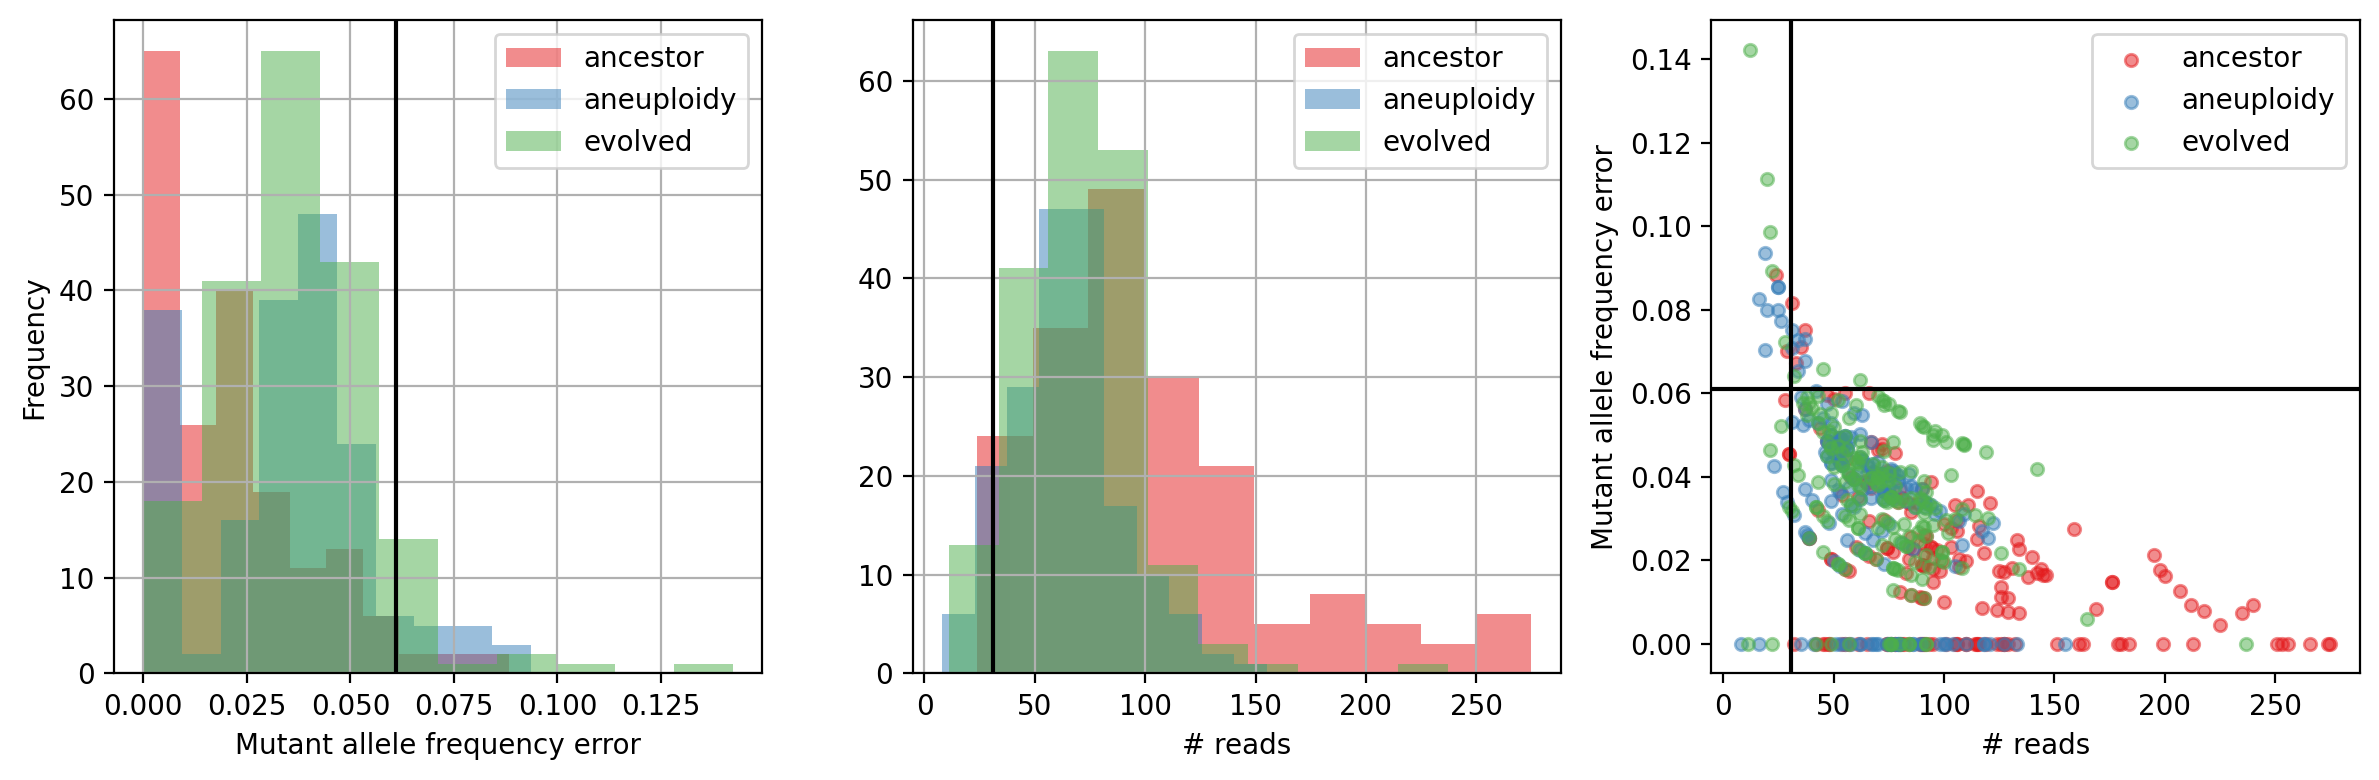

In [487]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
colors = sns.color_palette('Set1', 3)
colors = dict(zip(populations, colors))
alpha = 0.5

total_count = []
err = []
for i,t in enumerate(populations):
    total_count.append(data_B[t+'_total_count'])
    err.append(data_B[t+'_alt_err'])
total_count = np.array(total_count)
err = np.array(err)
n_q5 = np.percentile(total_count, 5)
e_q95 = np.percentile(np.array(err), 95)

ax = axes[0]
for i,t in enumerate(populations):
    c = colors[t]
    data_B[t+'_alt_err'].hist(ax=ax, alpha=alpha, label=t, color=c)
ax.axvline(e_q95, color='k')
ax.legend()
ax.set_xlabel('Mutant allele frequency error')
ax.set_ylabel('Frequency')

ax = axes[1]
for i,t in enumerate(populations):
    c = colors[t]
    data_B[t+'_total_count'].hist(ax=ax, alpha=alpha, label=t, color=c)
ax.axvline(n_q5, color='k')
ax.legend()
ax.set_xlabel('# reads')

ax = axes[2]
for i,t in enumerate(populations):
    c = colors[t]
    data_B.plot.scatter(t+'_total_count', t+'_alt_err', label=t, alpha=alpha, ax=ax, color=c)
ax.axvline(n_q5, color='k')
ax.axhline(e_q95, color='k')

ax.legend()
ax.set_xlabel('# reads')
ax.set_ylabel('Mutant allele frequency error')

fig.tight_layout()

In [488]:
# idx = (total_count > n_q5).all(axis=0)
# data_B = data_B[idx]
# print(data_B.shape)

# Analysis

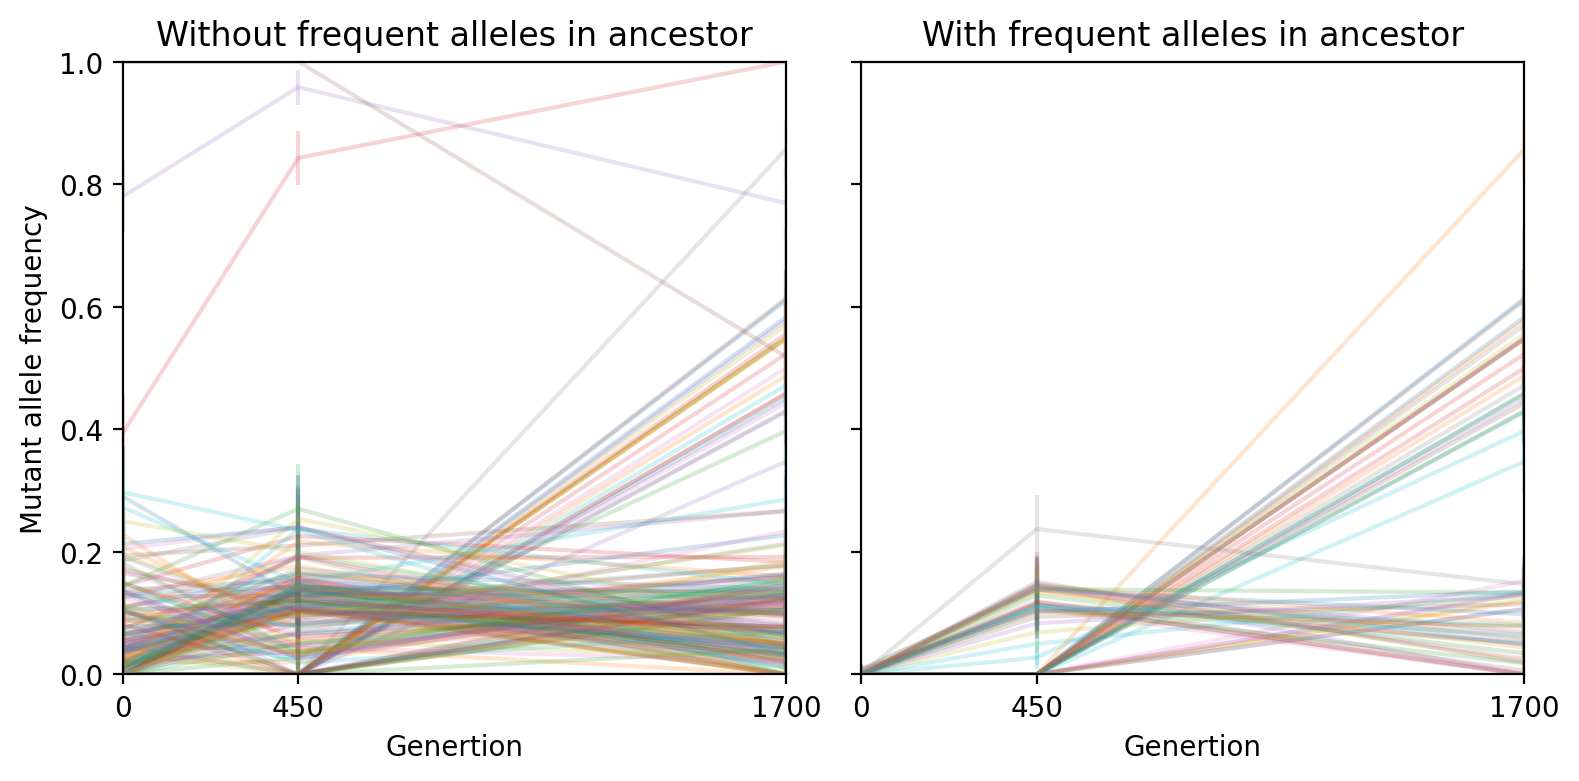

In [489]:
t = [0, 450, 1700]
th = 0.01

traj = data_B[['ancestor_alt','aneuploidy_alt','evolved_alt']].values
err = data_B[['ancestor_alt_err','aneuploidy_alt_err','evolved_alt_err']].values
idx = traj[:,0] < th

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
for x,e in zip(traj, err):
    axes[0].errorbar(t, x, yerr=e, alpha=0.2)
for x,e in zip(traj[idx], err[idx]):
    axes[1].errorbar(t, x, yerr=e, alpha=0.2)
axes[0].set(
    xticks=t, 
    ylim=(0, 1),
    xlim=(t[0], t[-1]),
    xlabel='Genertion',
    ylabel='Mutant allele frequency',
    title='Without frequent alleles in ancestor'
)
axes[1].set(
    xlabel='Genertion',
    title='With frequent alleles in ancestor'
)
fig.tight_layout()

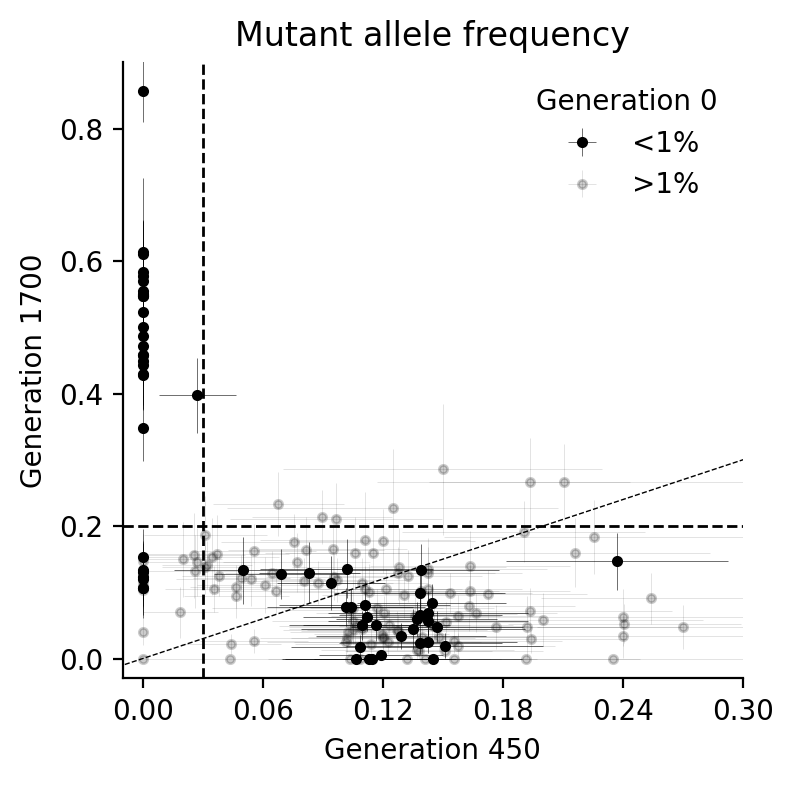

In [490]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
bins = np.linspace(0, 1, 100)
ax.errorbar(traj[idx, 1], traj[idx, 2], xerr=err[idx,1], yerr=err[idx,2], ls='', marker='.', c='k', elinewidth=0.2)
ax.errorbar(traj[~idx, 1], traj[~idx, 2], xerr=err[~idx,1], yerr=err[~idx,2], ls='', marker='.', c='k', alpha=0.2, elinewidth=0.2)
ax.legend(['<{:.0%}'.format(th), '>{:.0%}'.format(th)], title='Generation 0', frameon=False)
ax.axhline(0.2, color='k', ls='--', lw=1)
ax.axvline(0.03, color='k', ls='--', lw=1)
ax.plot(np.linspace(-1,1), np.linspace(-1,1), ls='--', color='k', lw=0.5)
ax.set(
    title='Mutant allele frequency',
    xlabel='Generation {}'.format(t[1]),
    ylabel='Generation {}'.format(t[-1]),
    xlim=(-0.01, 0.3),
    ylim=(-0.03, 0.9),
    xticks=np.arange(0, 0.33, 0.06),
    yticks=np.arange(0, 0.93, 0.2)
)
# ax.set_xticks()
sns.despine()